# FRETBursts - 8-spot smFRET burst analysis

*This notebook is part of a [tutorial series](https://github.com/tritemio/FRETBursts_notebooks) for the [FRETBursts](http://tritemio.github.io/FRETBursts/) burst analysis software.*

> For a step-by-step introduction to FRETBursts usage please refer to 
> [us-ALEX smFRET burst analysis](FRETBursts - us-ALEX smFRET burst analysis.ipynb).
>
> In this notebook we present a typical [FRETBursts](http://tritemio.github.io/FRETBursts/)
> workflow for **multi-spot smFRET burst analysis**. 
> Briefly, we show how to perform background estimation, burst search, burst selection, 
> FRET histograms, and FRET efficiency fit using different methods. 

## Loading the software

In [1]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.6.4).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [2]:
sns = init_notebook()

In [3]:
import lmfit; lmfit.__version__

'0.9.7'

In [4]:
import phconvert; phconvert.__version__

'0.7.3'

# Downloading the sample data file

The complete example dataset can be downloaded 
from [here](http://dx.doi.org/10.6084/m9.figshare.1019906).

Here we download an 8-spot smFRET measurement file using 
the `download_file` in FRETBursts: 

In [5]:
url = 'http://files.figshare.com/2182604/12d_New_30p_320mW_steer_3.hdf5'

In [6]:
download_file(url, save_dir='./data')

URL:  http://files.figshare.com/2182604/12d_New_30p_320mW_steer_3.hdf5
File: 12d_New_30p_320mW_steer_3.hdf5
 
File already on disk: /Users/anto/src/FRETBursts/notebooks/data/12d_New_30p_320mW_steer_3.hdf5 
Delete it to re-download.


# Selecting a data file

In [7]:
filename = "./data/12d_New_30p_320mW_steer_3.hdf5"

In [8]:
import os
assert os.path.exists(filename)

## Data load and Burst search

Load and process the data:

In [9]:
d = loader.photon_hdf5(filename)

For convenience we can set the correction coefficients right away 
so that they will be used in the subsequent analysis. 
The correction coefficients are: 

* leakage or bleed-through: `leakage`
* direct excitation: `dir_ex` (ALEX-only)
* gamma-factor `gamma`

The direct excitation cannot be applied to non-ALEX (single-laser) 
smFRET measurements (like the current one).

In [10]:
d.leakage = 0.038
d.gamma = 0.43

> **NOTE:** at any later moment, after burst search, a simple 
> reassignment of these coefficient will update the burst data 
> with the new correction values.

Compute background and burst search:

In [11]:
d.calc_bg(bg.exp_fit, time_s=30, tail_min_us='auto', F_bg=1.7)
d.burst_search(L=10, m=10, F=7)

 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


Perform a background plot as a function of the channel:

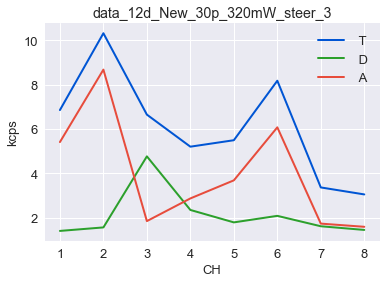

In [12]:
mch_plot_bg(d)

Let's take a look at the photon waiting times histograms and at the fitted background rates:

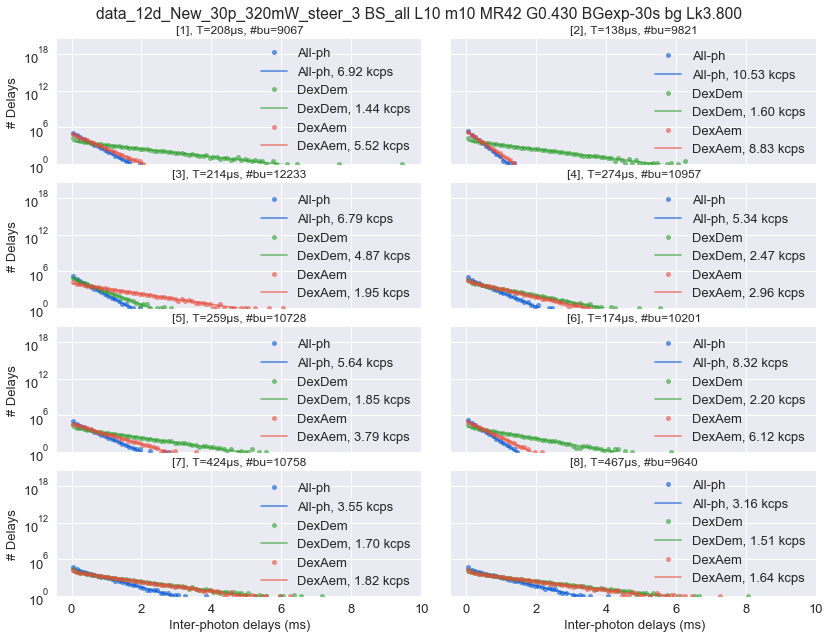

In [13]:
dplot(d, hist_bg);

Using `dplot` exactly in the same way as for the single-spot 
data has now generated 8 subplots, one for each channel.

Let's plot a timetrace for the background to see is there 
are significant variations during the measurement:

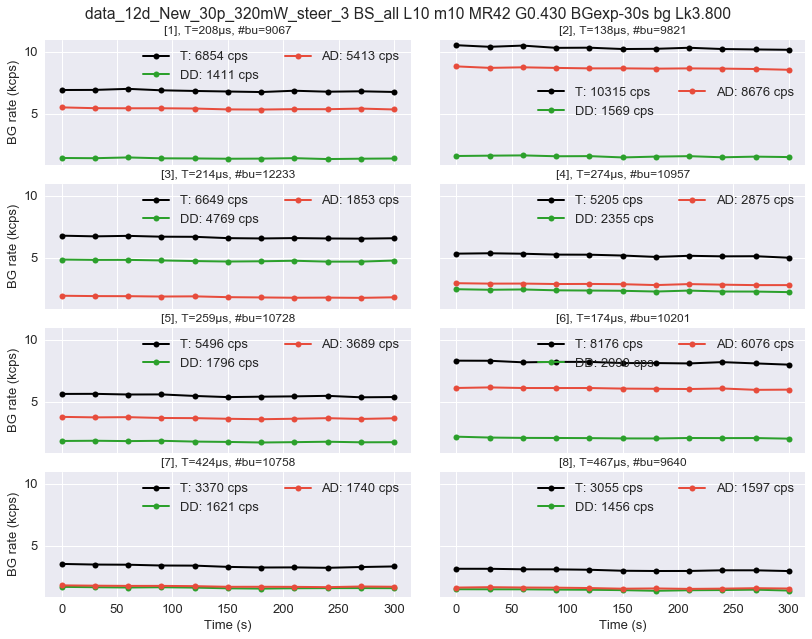

In [14]:
dplot(d, timetrace_bg);

We can look at the timetrace of the photon stream (binning):

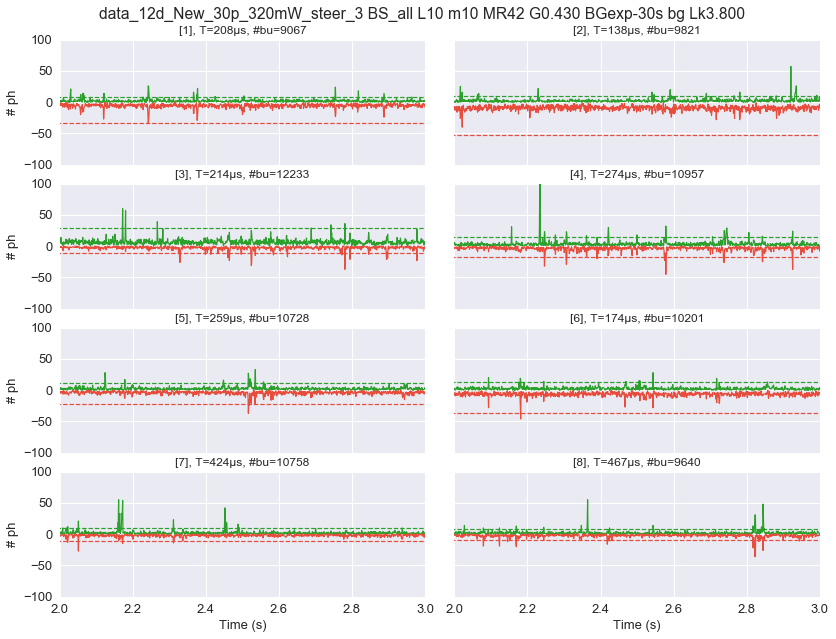

In [15]:
dplot(d, timetrace)
xlim(2, 3); ylim(-100, 100);

We can also open the same plot in an interactive window that allows scrolling (uncomment the following lines):

In [16]:
#%matplotlib qt

In [17]:
#dplot(d, timetrace, scroll=True);

In [18]:
#ylim(-100, 100)

In [19]:
#%matplotlib inline

## Burst selection and FRET

### Selecting bursts by burst size (`select_bursts.size`)

In [20]:
gamma = d.gamma
gamma

array(0.43)

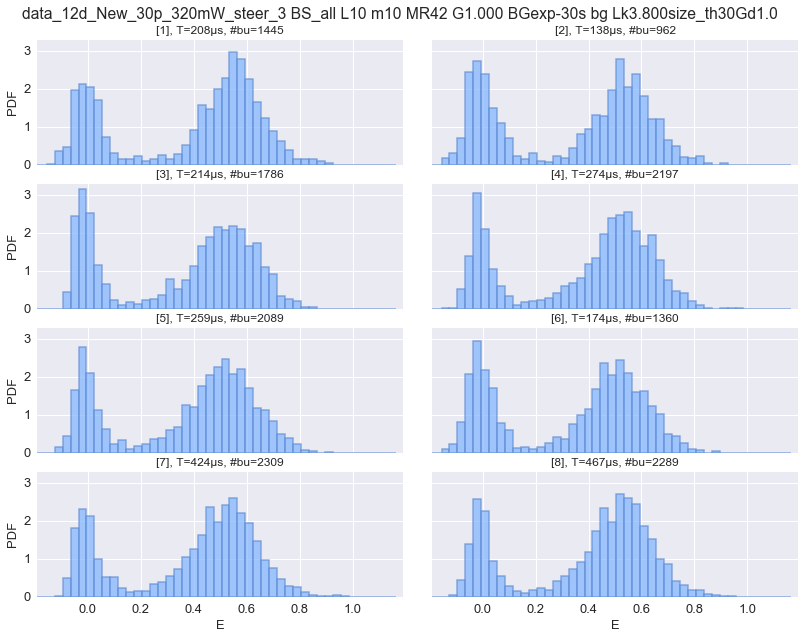

In [21]:
d.gamma = 1
ds = d.select_bursts(select_bursts.size, th1=30, gamma=1)
dplot(ds, hist_fret);

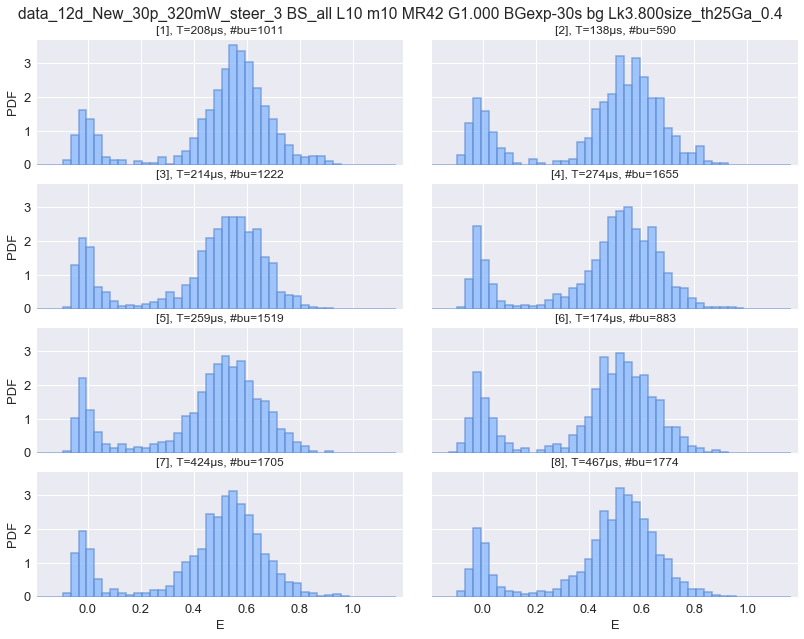

In [22]:
ds = d.select_bursts(select_bursts.size, th1=25, gamma=gamma, donor_ref=False)
dplot(ds, hist_fret);

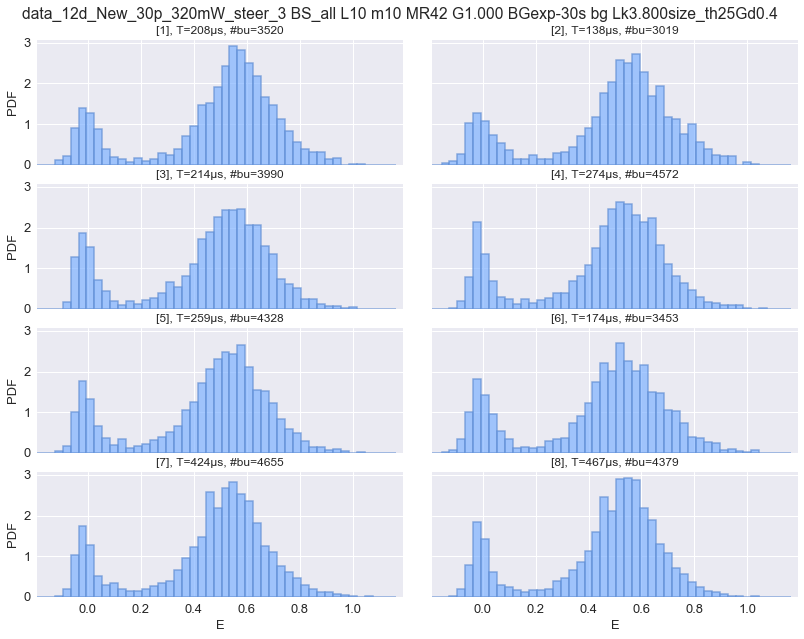

In [23]:
ds = d.select_bursts(select_bursts.size, th1=25, gamma=gamma)
dplot(ds, hist_fret, weights='size', gamma=gamma);

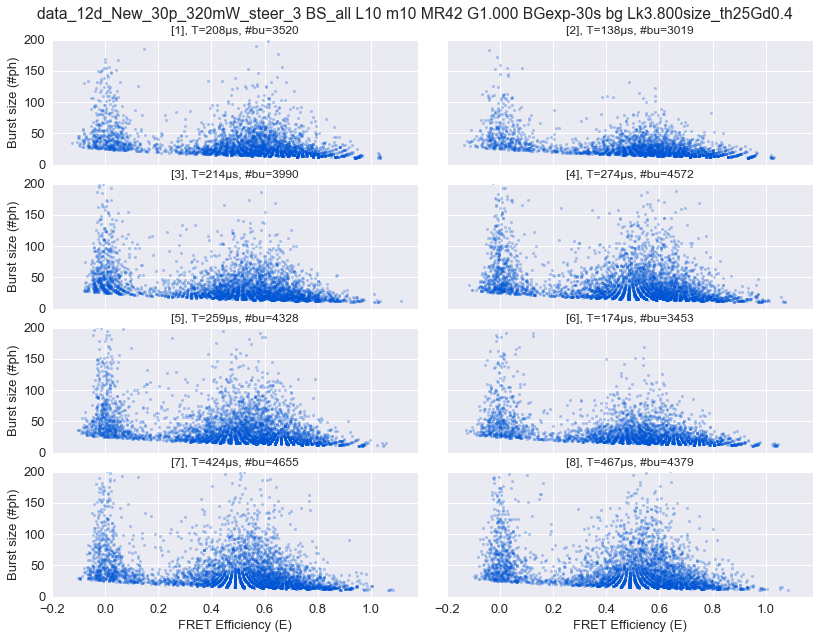

In [24]:
dplot(ds, scatter_fret_nd_na); ylim(0,200);

## FRET Fitting

### 2-Gaussian mixture

Let's fit the $E$ histogram with a 2-Gaussians model:

In [25]:
ds.gamma = 1.
bext.bursts_fitter(ds, weights=None)
ds.E_fitter.fit_histogram(mfit.factory_two_gaussians(), verbose=False)

The fitted parameters are stored in a pandas DataFrame:

In [26]:
ds.E_fitter.params

,p1_amplitude,p1_center,p1_sigma,p2_amplitude,p2_center,p2_sigma
0,0.161037,0.0147363,0.054972,0.827205,0.587919,0.144063
1,0.154906,0.0165125,0.065014,0.830402,0.592552,0.147132
2,0.172021,0.00363337,0.0429549,0.818251,0.56242,0.148298
3,0.151185,0.00576416,0.0410726,0.827219,0.565177,0.14754
4,0.155672,0.00718107,0.0442892,0.830064,0.558945,0.15308
5,0.169139,0.00913894,0.0535911,0.822227,0.561622,0.153229
6,0.15287,0.00624211,0.0480221,0.82579,0.559307,0.143679
7,0.154317,0.00772731,0.0412279,0.822823,0.556762,0.138972


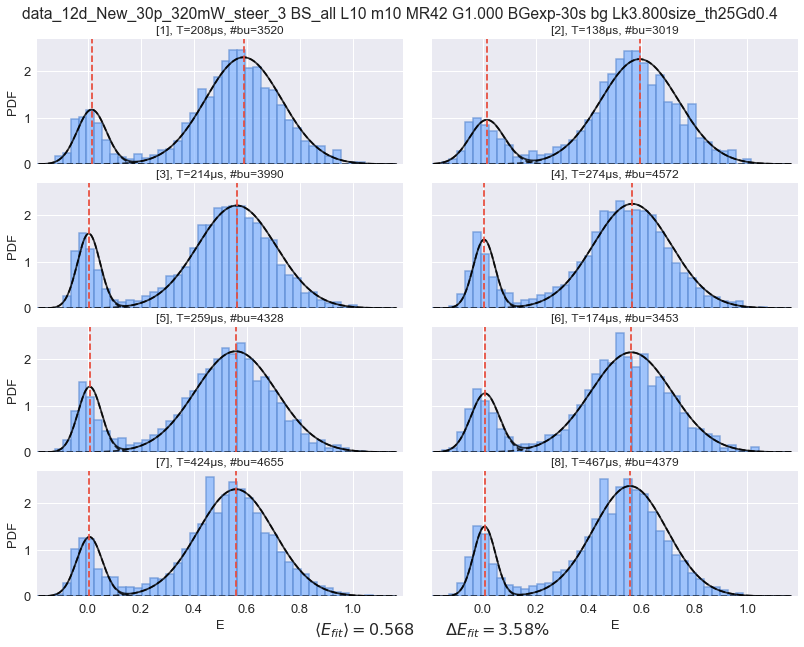

In [27]:
dplot(ds, hist_fret, weights=None, show_model=True,
      show_fit_stats=True, fit_from='p2_center');

### Weighted Expectation Maximization

The [expectation maximization](http://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) 
(EM) method is particularly suited to resolve population 
mixtures. Note that the EM algorithm does not fit the histogram 
but the $E$ distribution with no binning.

FRETBursts include a weighted version of the EM algorithm that 
can take into account the burst size.
The algorithm and benchmarks with the 2-Gaussian histogram fit 
are reported [here](http://nbviewer.ipython.org/github/tritemio/notebooks/blob/master/Mixture_Model_Fitting.ipynb).

You can find the EM algorithm in `fretbursts/fit/gaussian_fit.py` or typing:

`bl.two_gaussian_fit_EM??`


In [28]:
# bl.two_gaussian_fit_EM??

In [29]:
EM_results = ds.fit_E_two_gauss_EM(weights=None, gamma=1.)
EM_results

array([ 0.59034917,  0.59434693,  0.55839   ,  0.56483743,  0.55495784,
        0.56629197,  0.56123037,  0.55425976])

The fitted parameters for each channel are stored in the `fit_E_res` attribute:

In [30]:
ds.fit_E_name, ds.fit_E_res

('two_gaussian_fit_EM',
 array([[ 0.01827043,  0.05425973,  0.59034917,  0.15131662,  0.16027376],
        [ 0.02444544,  0.06319074,  0.59434693,  0.15595512,  0.15279001],
        [ 0.00983905,  0.04251182,  0.55839   ,  0.15521184,  0.17085603],
        [ 0.01439771,  0.04672438,  0.56483743,  0.1568168 ,  0.15776558],
        [ 0.01588614,  0.04910262,  0.55495784,  0.15943355,  0.16035786],
        [ 0.01408364,  0.05310594,  0.56629197,  0.15905434,  0.16854415],
        [ 0.01827203,  0.05202844,  0.56123037,  0.15336734,  0.15783566],
        [ 0.01465007,  0.04537403,  0.55425976,  0.1493034 ,  0.15880772]]))

The model function is stored in:

In [31]:
ds.fit_E_model

<function fretbursts.fit.gaussian_fitting.two_gauss_mix_pdf>

Let's plot the histogram and the model with parameters from the EM fit:

E mean: 56.81%   E delta: 4.01%


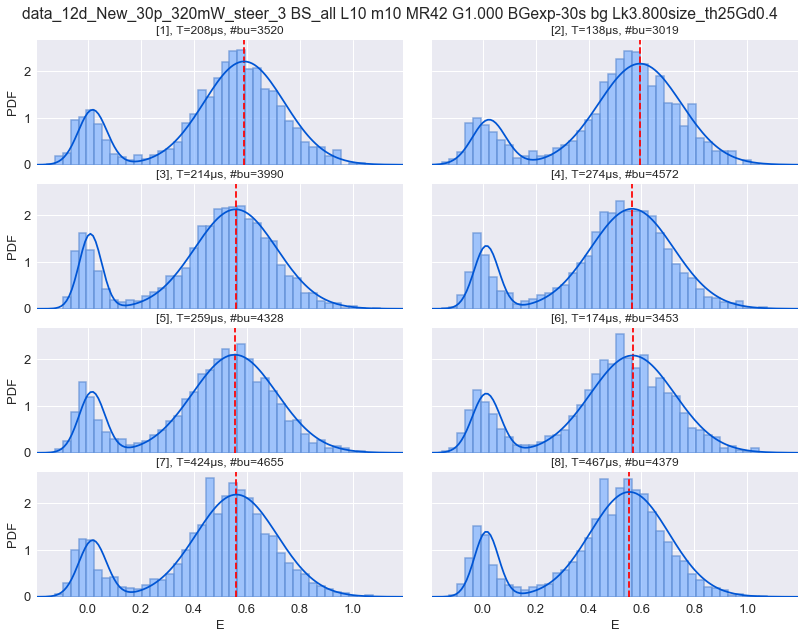

In [32]:
AX = dplot(ds, hist_fret, weights=None)

x = np.r_[-0.2: 1.2 : 0.01]
for ich, (ax, E_fit) in enumerate(zip(AX.ravel(), EM_results)):
    ax.axvline(E_fit, ls='--', color='r')
    ax.plot(x, ds.fit_E_model(x, ds.fit_E_res[ich]))

print('E mean: %.2f%%   E delta: %.2f%%' %\
      (EM_results.mean()*100, (EM_results.max() - EM_results.min())*100))

## Comparing 2-Gaussian and EM fit

To quickly compare the 2-Gaussians with the EM fit we convert the EM fit results in a DataFrame:

In [33]:
import pandas as pd

In [34]:
EM_results = pd.DataFrame(ds.fit_E_res, columns=['p1_center', 'p1_sigma', 'p2_center', 'p2_sigma', 'p1_amplitude'])
EM_results * 100

,p1_center,p1_sigma,p2_center,p2_sigma,p1_amplitude
0,1.827043,5.425973,59.034917,15.131662,16.027376
1,2.444544,6.319074,59.434693,15.595512,15.279001
2,0.983905,4.251182,55.839000,15.521184,17.085603
3,1.439771,4.672438,56.483743,15.681680,15.776558
4,1.588614,4.910262,55.495784,15.943355,16.035786
5,1.408364,5.310594,56.629197,15.905434,16.854415
6,1.827203,5.202844,56.123037,15.336734,15.783566
7,1.465007,4.537403,55.425976,14.930340,15.880772


In [35]:
ds.E_fitter.params * 100

,p1_amplitude,p1_center,p1_sigma,p2_amplitude,p2_center,p2_sigma
0,16.1037,1.47363,5.4972,82.7205,58.7919,14.4063
1,15.4906,1.65125,6.5014,83.0402,59.2552,14.7132
2,17.2021,0.363337,4.29549,81.8251,56.242,14.8298
3,15.1185,0.576416,4.10726,82.7219,56.5177,14.754
4,15.5672,0.718107,4.42892,83.0064,55.8945,15.308
5,16.9139,0.913894,5.35911,82.2227,56.1622,15.3229
6,15.287,0.624211,4.80221,82.579,55.9307,14.3679
7,15.4317,0.772731,4.12279,82.2823,55.6762,13.8972


And we compute the difference between the two sets of parameters:

In [36]:
(ds.E_fitter.params - EM_results) * 100

,p1_amplitude,p1_center,p1_sigma,p2_amplitude,p2_center,p2_sigma
0,0.0763545,-0.353408,0.0712314,NaN,-0.243056,-0.725374
1,0.211625,-0.793297,0.182326,NaN,-0.179468,-0.882325
2,0.11648,-0.620568,0.0443054,NaN,0.403039,-0.691339
3,-0.658073,-0.863354,-0.565177,NaN,0.0339524,-0.92766
4,-0.468606,-0.870507,-0.481347,NaN,0.398677,-0.635384
5,0.0594654,-0.494469,0.0485184,NaN,-0.467037,-0.582538
6,-0.496595,-1.20299,-0.400634,NaN,-0.192344,-0.968818
7,-0.449082,-0.692275,-0.414617,NaN,0.250206,-1.03316


> **NOTE:** The EM method follows more the "asymmetry" of the 
> peaks because the center is a weighted mean of the bursts. 
> On the contrary the 2-Gaussians histogram fit tends to follows 
> more the peak position an less the "asymmetric" tails.  

---
**Executed:** Tue Jul 11 21:52:49 2017

**Duration:** 29 seconds.

**Autogenerated from:** [FRETBursts - 8-spot smFRET burst analysis.ipynb](out/FRETBursts - 8-spot smFRET burst analysis.ipynb)